# The Caring Home / Helpful Home Continued

A model that can look for non normal situations in a elderly person home, from smart home IoT sensors.

## Enter The Tabular Data Model!

And now - we put Tabular Data Models to the test.



In [12]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import joblib


In [13]:
# Import the machine learning libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tabpfn import TabPFNClassifier



In [14]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [15]:
# environment

load_dotenv()


True

In [16]:
%matplotlib inline

In [17]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

## First, the TabPFN

It's called TabPFN, Its a foundation model for tabular data that outperforms traditional methods while being dramatically faster. This repository contains the core PyTorch implementation with CUDA optimization.

In [18]:
train[0].details

'[{"timestamp": 1738684800, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1738684860, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738684920, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}, {"timestamp": 1738684980, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738685040, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}]\n'

In [19]:
#Here comments some feature engineering to convert the raw sensor data into meaningful features dynamically.
def flatten_entry(entry):
    """Flatten a single JSON-like entry with indexed keys."""
    flat_dict = {}
    logs = json.loads(entry.details.strip())


    for i, log in enumerate(logs):
        for key, value in log.items():
            flat_dict[f"{i}.{key}"] = value

    flat_dict['result'] = entry.result
    return flat_dict


def prepare_features(data):
    """Convert the raw sensor data into meaningful features dynamically."""
    features = {}
    
    # Get all events for this day
    try:
        events = json.loads(data.details)
    except json.JSONDecodeError:
        return features  # Return empty if details are not parseable

    if not events:
        return features  # No events, return empty features

    # Feature 1: Unique room visits and their counts
    room_counts = {}  # Count visits per room
    event_counts = {}  # Count occurrences of each event type
    timestamps = []  # To track time-based features

    for event in events:
        room = event.get('room', 'unknown')
        event_type = event.get('event', 'none')
        timestamp = event.get('timestamp')

        # Update room and event counts
        room_counts[room] = room_counts.get(room, 0) + 1
        event_counts[event_type] = event_counts.get(event_type, 0) + 1

        # Track timestamps for time-based calculations
        if timestamp is not None:
            timestamps.append(timestamp)

    # Add dynamic room counts
    for room, count in room_counts.items():
        features[f'room_{room}_visits'] = count

    # Add dynamic event counts
    for event_type, count in event_counts.items():
        features[f'event_{event_type}_count'] = count

    # Feature 2: Time-based features
    if len(timestamps) > 1:
        timestamps.sort()
        time_diffs = np.diff(timestamps)
        features['avg_time_between_events'] = np.mean(time_diffs)
        features['max_time_between_events'] = np.max(time_diffs)
        features['min_time_between_events'] = np.min(time_diffs)
        features['num_rapid_transitions'] = sum(diff < 120 for diff in time_diffs)
    else:
        # Default values if not enough timestamps
        features['avg_time_between_events'] = 0
        features['max_time_between_events'] = 0
        features['min_time_between_events'] = 0
        features['num_rapid_transitions'] = 0

    return features


In [20]:
prepare_features(test[6])

{'room_kitchen_visits': 3,
 'event_none_count': 3,
 'avg_time_between_events': np.float64(300.0),
 'max_time_between_events': np.int64(540),
 'min_time_between_events': np.int64(60),
 'num_rapid_transitions': np.int64(1)}

In [21]:
# We are going to flatten the log entries and turn into tabular data

def flatten_entry(entry):
    """Flatten a single JSON-like entry with indexed keys."""
    flat_dict = {}
    logs = json.loads(entry.details.strip())


    for i, log in enumerate(logs):
        for key, value in log.items():
            flat_dict[f"{i}.{key}"] = value

    flat_dict['result'] = entry.result
    return flat_dict


def prepare_tabular_data2(data, feature_names=None):
    """Convert a list of JSON entries into a Pandas DataFrame."""
    flattened_data = [flatten_entry(entry) for entry in data]
    df = pd.DataFrame(flattened_data)
    df = df.fillna('missing')  # Handle missing values
    
    if feature_names:
        missing_features = {feature: 'missing' for feature in feature_names if feature not in df.columns}
        df = pd.concat([df, pd.DataFrame(missing_features, index=df.index)], axis=1)
        df = df[feature_names]
    
    return df.astype(str)  # Ensure all data is of string type

def prepare_tabular_data(data, feature_names=None):
    """Convert a list of JSON entries into a Pandas DataFrame with engineered features."""
    flattened_data = []
    for entry in data:
        features = prepare_features(entry)
        features['result'] = entry.result
        flattened_data.append(features)
    
    df = pd.DataFrame(flattened_data)
    df = df.fillna('missing')  # Handle missing values
    
    if feature_names:
        missing_features = {feature: 'missing' for feature in feature_names if feature not in df.columns}
        df = pd.concat([df, pd.DataFrame(missing_features, index=df.index)], axis=1)
        df = df[feature_names]
    
    return df.astype(str)  # Ensure all data is of string type

In [22]:
prepare_tabular_data(train)

,room_kitchen_visits,event_none_count,avg_time_between_events,max_time_between_events,min_time_between_events,num_rapid_transitions,result,room_bathroom_visits,room_livingroom_visits,room_bedroom_visits,room_pillbox_visits,room_hall_visits,room_porch_visits,event_cabinet_opened_count,event_fridge_opened_count
0,5.0,5,60.0,60,60,4,anomalous,missing,missing,missing,missing,missing,missing,missing,missing
1,missing,2,300.0,300,300,0,normal,2.0,missing,missing,missing,missing,missing,missing,missing
2,missing,3,60.0,60,60,2,normal,3.0,missing,missing,missing,missing,missing,missing,missing
3,2.0,3,60.0,60,60,2,normal,missing,1.0,missing,missing,missing,missing,missing,missing
4,1.0,3,1830.0,3600,60,1,anomalous,missing,missing,2.0,missing,missing,missing,missing,missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,6.0,31,1780.0,16140,60,8,anomalous,3.0,9.0,5.0,3.0,3.0,2.0,missing,missing
84,missing,4,1220.0,3540,60,2,normal,missing,missing,missing,4.0,missing,missing,missing,missing
85,missing,4,60.0,60,60,3,anomalous,4.0,missing,missing,missing,missing,missing,missing,missing
86,missing,3,60.0,60,60,2,anomalous,3.0,missing,missing,missing,missing,missing,missing,missing


In [23]:
# We will train the anomlay detector using the tabPFN model

def train_anomaly_detector(json_data):
    """Train a TabPFN model to detect anomalies."""
    df = prepare_tabular_data(json_data)
    
    # Separate features and labels
    X = df.drop(columns=['result'], errors='ignore')
    y = (df['result'] == 'anomalous').astype(int)  # Binary classification

    # Convert all columns to string type to avoid type issues
    X = X.astype(str)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize TabPFN classifier
    model = TabPFNClassifier()
    model.fit(X_train, y_train)

    # Predict probabilities
    prediction_probabilities = model.predict_proba(X_test)
    print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

    # Predict labels
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    return model, X_train.columns.tolist()


In [24]:
# Lets create a model
model, feature_names = train_anomaly_detector(train)

ROC AUC: 0.9480519480519481
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.92      1.00      0.96        11

    accuracy                           0.94        18
   macro avg       0.96      0.93      0.94        18
weighted avg       0.95      0.94      0.94        18



In [25]:
# We make a function to predict an anomaly
def predict_anomaly(model, new_data, feature_names):
    """Predict if a new datapoint is anomalous using TabPFN."""
    df = prepare_tabular_data([new_data], feature_names)
    X = df.drop(columns=['result'], errors='ignore')

    # Ensure no NaN values are present
    X = X.fillna('missing')

    # Ensure the feature order matches the training order
    X = X[feature_names]

    prediction = model.predict(X)
    probability = model.predict_proba(X)

    return {
        'is_anomalous': bool(prediction[0]),
        'confidence': float(max(probability[0])),
        'features_used': list(X.columns)
    }


In [26]:
test[0].details = '[{"timestamp":1738152000,"room":"pillbox","nodeId":1,"onOff":true},{"timestamp":1738152060,"room":"bedroom","nodeId":2,"onOff":true},{"timestamp":1738152300,"room":"bathroom","nodeId":2,"onOff":true},{"timestamp":1738152600,"room":"bathroom","nodeId":3,"humidity":6500},{"timestamp":1738152900,"room":"bathroom","nodeId":2,"onOff":false},{"timestamp":1738153200,"room":"kitchen","nodeId":2,"onOff":true},{"timestamp":1738153260,"room":"kitchen","event":"fridge_opened"},{"timestamp":1738153800,"room":"kitchen","nodeId":2,"onOff":false},{"timestamp":1738154100,"room":"livingroom","nodeId":2,"onOff":true},{"timestamp":1738154400,"room":"livingroom","nodeId":1,"occupancy":1},{"timestamp":1738155600,"room":"livingroom","nodeId":2,"onOff":false},{"timestamp":1738156800,"room":"hall","nodeId":1,"occupancy":1},{"timestamp":1738157400,"room":"porch","nodeId":1,"occupancy":1},{"timestamp":1738157460,"room":"hall","nodeId":1,"occupancy":0},{"timestamp":1738173600,"room":"porch","nodeId":1,"occupancy":0},{"timestamp":1738184400,"room":"porch","nodeId":1,"occupancy":0},{"timestamp":1738195200,"room":"porch","nodeId":1,"occupancy":0},{"timestamp":1738206000,"room":"porch","nodeId":1,"occupancy":0},{"timestamp":1738206100,"room":"ballroom","nodeId":1,"occupancy":0},{"timestamp":1738206200,"room":"snookerroom","nodeId":1,"occupancy":0}]'

In [27]:
test[0].details

'[{"timestamp":1738152000,"room":"pillbox","nodeId":1,"onOff":true},{"timestamp":1738152060,"room":"bedroom","nodeId":2,"onOff":true},{"timestamp":1738152300,"room":"bathroom","nodeId":2,"onOff":true},{"timestamp":1738152600,"room":"bathroom","nodeId":3,"humidity":6500},{"timestamp":1738152900,"room":"bathroom","nodeId":2,"onOff":false},{"timestamp":1738153200,"room":"kitchen","nodeId":2,"onOff":true},{"timestamp":1738153260,"room":"kitchen","event":"fridge_opened"},{"timestamp":1738153800,"room":"kitchen","nodeId":2,"onOff":false},{"timestamp":1738154100,"room":"livingroom","nodeId":2,"onOff":true},{"timestamp":1738154400,"room":"livingroom","nodeId":1,"occupancy":1},{"timestamp":1738155600,"room":"livingroom","nodeId":2,"onOff":false},{"timestamp":1738156800,"room":"hall","nodeId":1,"occupancy":1},{"timestamp":1738157400,"room":"porch","nodeId":1,"occupancy":1},{"timestamp":1738157460,"room":"hall","nodeId":1,"occupancy":0},{"timestamp":1738173600,"room":"porch","nodeId":1,"occupancy

In [28]:
# Example usage:
result = predict_anomaly(model, test[0], feature_names)
print(result)

{'is_anomalous': True, 'confidence': 0.5982423424720764, 'features_used': ['room_kitchen_visits', 'event_none_count', 'avg_time_between_events', 'max_time_between_events', 'min_time_between_events', 'num_rapid_transitions', 'room_bathroom_visits', 'room_livingroom_visits', 'room_bedroom_visits', 'room_pillbox_visits', 'room_hall_visits', 'room_porch_visits', 'event_cabinet_opened_count', 'event_fridge_opened_count']}


In [29]:
def tabpfn_anomaly_assessor(item):
    """Wrapper function to assess anomalies using TabPFN."""
    result = predict_anomaly(model, item, feature_names)
    return 'anomalous' if result['is_anomalous'] else 'normal'

1: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp":1738152000,"room":"pillbox...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738238400, "room": "pill...
3: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739170800, "room": "pill...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1739089200, "room": "bedr...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1739374800, "room": "bath...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738734000, "room": "pill...
7: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739277600, "room": "kitc...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1739336400, "room": "bedr...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738623600, "room": "kitc...
10: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738623600, "room": "hall...
11: Guess: anomalous Truth: anoma

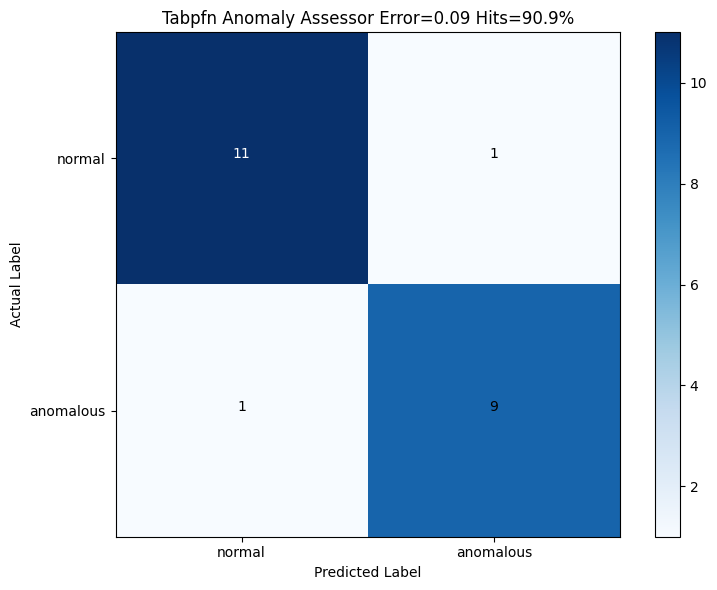

In [30]:
#Now lets run the test
Tester.test(tabpfn_anomaly_assessor, test)


# Now we should save our classification model

In [31]:
# Save the model and scaler to a file

joblib.dump((model, feature_names), 'tabpfn_model.pkl')

['tabpfn_model.pkl']